In [1]:
import numpy as np
import torch
import torchvision.utils as vutils
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from cyclegan.model import Generator as CycleGenerator
from stargan2.model import Generator as StarGenerator
from stargan2.model import StyleEncoder

device = torch.device('cpu')

In [8]:
import torchvision.models.resnet as resnet

class ResNet(resnet.ResNet):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self._forward_impl(x))

def normalize(x):
    out = (x-.5)/.5
    return torch.from_numpy(out)
def denormalize(x):
    return (x + 1) / 2

def eval_G(validation_loader):
    acc = .0
    for i, data in enumerate(validation_loader):
        X = data[0]
        y_s = data[2]
        s = starE(X, y_s)

        X_g = starG(X, s)
        predicted = torch.round(Clf(denormalize(X_g)))

        y = data[1]
        acc+=(predicted == y).sum()/float(predicted.shape[0])     
#             acc_g+=(predicted_g == y).sum()/float(predicted_g.shape[0])     
    return (acc/(i+1)).detach().item()

In [6]:
from torch.utils.data import DataLoader, TensorDataset

X0_val = np.load('X0_val_clean_48.npy') 
X1_val = np.load('X1_val_clean_48.npy')


X_val = normalize(np.concatenate([X0_val, X1_val]))
y_val = torch.from_numpy(np.concatenate([np.load('y0_val_clean_48.npy'), np.load('y1_val_clean_48.npy')]))
# define target labels for each style 
y_s_val = torch.tensor([1]*len(X0_val)+[0]*len(X1_val))

valloader = DataLoader(TensorDataset(X_val, y_val, y_s_val), batch_size=128, shuffle=True, num_workers=0)

Clf = ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1)
Clf.load_state_dict(torch.load('results/clf_resnet18_48/best_model.pth', map_location=device));

In [43]:
# cycA = CycleGenerator()
# cycA.load_state_dict(torch.load('results/cyclegan_48_r1/netG_A2B.pth', map_location=device))
# cycA.eval()

# cycB = CycleGenerator()
# cycB.load_state_dict(torch.load('results/cyclegan_48_r1/netG_B2A.pth', map_location=device))
# cycB.eval()

# starG = StarGenerator(48, 64)
# starG.load_state_dict(torch.load('results/StarGAN2_48_ds1/G.pth', map_location=device))

# starE = StyleEncoder(48, 64, 2)
# starE.load_state_dict(torch.load('results/StarGAN2_48_ds1/E.pth', map_location=device))

X0_samples = X0_val[random.sample(range(len(X0_val)), 10)]
# X1_samples = X1_val[random.sample(range(len(X1_val)), 10)]


s0 = starE(normalize(X0_samples), torch.ones(10, dtype=torch.long))
# s1 = starE(normalize(X1_samples), torch.zeros(10, dtype=torch.long))

In [9]:
eval_G(valloader)

0.7519872188568115

In [10]:
acc = eval_G(valloader)

In [11]:
acc

0.7520142197608948

Here is the comparation of 2 style transfer networks: CycleGAN and StarGAN v2. The networks were trained on CAMELYON16 dataset. The accuracy represents a classification of real and translated images using a pre-trained classifier.

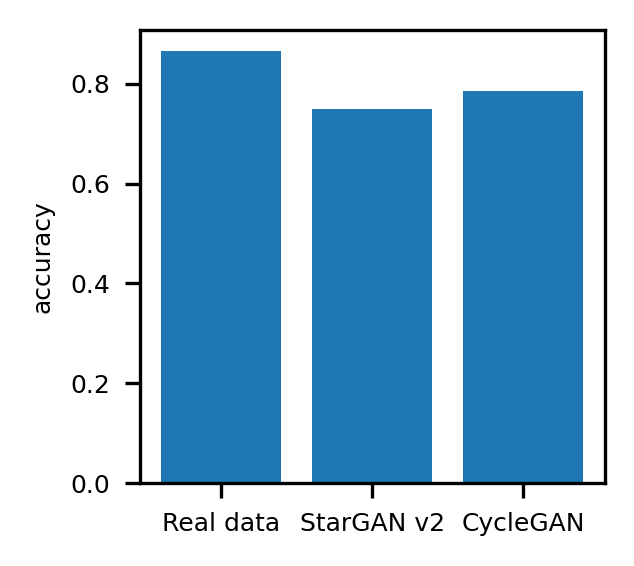

In [47]:
plt.figure(figsize=(2, 2))
plt.bar(['Real data', 'StarGAN v2', 'CycleGAN'], [(.85+.88)/2, .75, (.76+.81)/2])
plt.ylabel('accuracy', fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6);
# plt.box(False)

The next two figures demonstrate the quality of translated images for the 2 networks. First row is reference images sampled from validation dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


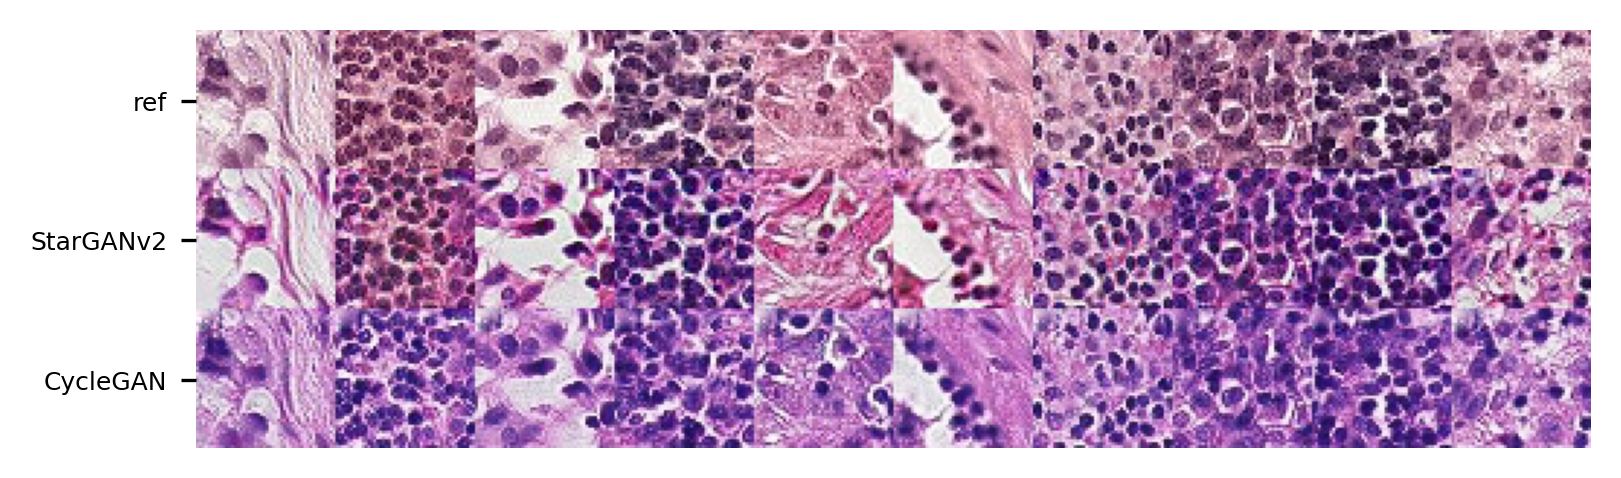

In [44]:
imgs_ref = torch.from_numpy(X0_samples)
cycA_imgs = denormalize(cycA(normalize(X0_samples)).detach())
starA_imgs = denormalize(starG(normalize(X0_samples), s0).detach())
imgsA2B = torch.cat([imgs_ref, starA_imgs, cycA_imgs], dim=0)


fig = plt.figure()
img = np.transpose(vutils.make_grid(imgsA2B, padding=0, nrow=10).numpy(), (1, 2, 0))
plt.imshow(img)
plt.box(False)
# plt.axis('off')
# plt.title('')
plt.xticks([], [])
plt.yticks([48//2, 48+48//2,2*48+48//2], ['ref', 'StarGANv2', 'CycleGAN'], fontsize=6);
# plt.yticks(rotation=45)
# plt.tick_params(length=0, labelsize=7)


In [1]:
imgs_ref = torch.from_numpy(X1_samples)
cycB_imgs = denormalize(cycB(normalize(X1_samples)).detach())
starB_imgs = denormalize(starG(normalize(X1_samples), s1).detach())

imgsB2A = torch.cat([imgs_ref, starB_imgs, cycB_imgs], dim=0)


fig = plt.figure()
img = np.transpose(vutils.make_grid(imgsB2A, padding=0, nrow=10).numpy(), (1, 2, 0))
plt.imshow(img)
plt.box(False)
plt.xticks([], [])
plt.yticks([48//2, 48+48//2,2*48+48//2], ['ref', 'StarGANv2', 'CycleGAN'], fontsize=6);
# plt.xticks([], [])
# plt.yticks(ticks, labels)
# plt.yticks(rotation=90)
# plt.tick_params(length=0, labelsize=7)


NameError: name 'torch' is not defined

In [2]:
import sympy as sym

In [3]:
a, b, c = sym.symbols("sigma, alpha_c, gamma_r")

In [4]:
a

sigma

In [5]:
expr=(a+b+c)**2

In [6]:
expr.expand()

alpha_c**2 + 2*alpha_c*gamma_r + 2*alpha_c*sigma + gamma_r**2 + 2*gamma_r*sigma + sigma**2

In [7]:
expr.diff(a)

2*alpha_c + 2*gamma_r + 2*sigma

In [10]:
sym.latex(expr)

'\\left(\\alpha_{c} + \\gamma_{r} + \\sigma\\right)^{2}'

In [56]:

x = sym.Symbol("x")
expr = sym.sin(x)
ex = sym.series(expr, x, 0, 20)
from sympy import Order

NameError: name 'O' is not defined

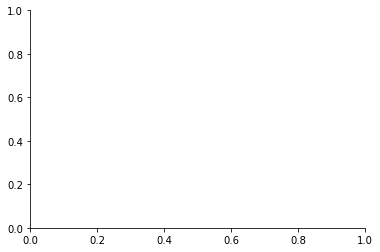

In [57]:
sym.plot(ex)

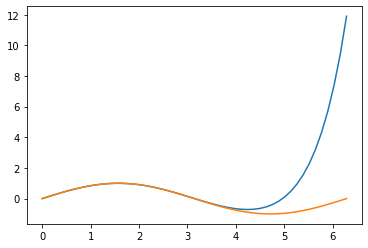

In [47]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2*np.pi)
y = x-x**3/6 + x**5/120 - x**7/5040 + x**9/362880
plt.plot(x, y)
plt.plot(x, np.sin(x))
# plt.xlim([0, 2*np.pi])